# Z01.3: Token Length Analysis

This notebook contains the analysis of Token Lengths. This is the first analysis of first Scribal Intent Study (Z01).

## Setup and Utility Functions

In [1]:
# Imports and setup
import pandas as pd
import scipy.stats as stats

from qlynx.file_utils import load_pkl
from qlynx.plot_utils import plot_combined_curves
from qlynx.plot_utils import plot_heatmap_Z001
from qlynx.plot_utils import plot_adjacent_histograms_with_binomial_curves
from qlynx.stats_utils import *
from voynichlib.ProbMassFunction import ProbMassFunction

%reload_ext autoreload
%autoreload 2


In [2]:
bayes_factor_binomial(0, 300, 0, .01)

20.39114536832058

## Load the Token Cohort Data

In [3]:
file_path = 'voynich_data/outputs/token_cohort_data.pkl'
token_cohort_data = load_pkl(file_path)

all_cohorts = token_cohort_data['all_cohorts']
cohorts = token_cohort_data['cohorts']
cohorts_with_randoms = token_cohort_data['cohorts_with_randoms']

corpus_by_c = token_cohort_data['corpus_by_c']
pmfs_by_c = token_cohort_data['pmfs_by_c']
pmfs_by_cw = token_cohort_data['pmfs_by_cw']
tokens_by_cw = token_cohort_data['tokens_by_cw']
token_ws_by_c = token_cohort_data['token_ws_by_c']

glyph_pmfs_by_c = token_cohort_data['glyph_pmfs_by_c']
glyphs_by_c = token_cohort_data['glyphs_by_c']

## Corpus Token Length Summaries

In [4]:
def make_token_length_summary_table(cohorts):
    df = pd.DataFrame(columns=['Cohort', 'Mean', 'StDev', 'Min', 'Max', 'Observations'])
    for cohort in cohorts:   
        # if cohort.startswith('Rand'):
            
        token_lengths = token_ws_by_c[cohort]
        # corpus_by_c[cohort].tokens_df()['token_length_min' ]
        df.loc[len(df)] = [cohort,
                           np.mean(token_lengths),
                           np.std(token_lengths),
                           np.min(token_lengths),
                           np.max(token_lengths),
                           len(token_lengths)]
        pass    
    df.to_csv('voynich_data/outputs/token_length_summary_data.csv')
    return df
df = make_token_length_summary_table(['ALL'] + cohorts_with_randoms)
df

,Cohort,Mean,StDev,Min,Max,Observations
0,ALL,4.722846,1.792522,1,13,7660
1,MIDDLE,4.579984,1.694364,1,12,3807
2,TOP,5.037780,1.812586,1,11,847
3,FIRST,5.128257,1.753777,1,11,998
4,LAST,4.465894,1.912953,1,13,777
5,BEFORE,4.243553,1.956766,1,9,349
6,AFTER,4.658273,1.625489,1,9,278
7,SECOND,4.656701,1.653700,1,10,970
8,FOURTH,4.683068,1.717195,1,12,691
9,RAND 1,4.620619,1.655478,1,10,970


In [5]:
def make_token_length_summary_table(cohorts):
    df = pd.DataFrame(columns=['Cohort', 'Mean', 'Std', 'Min', 'Max', 'Num_Obs'])
    for cohort in all_cohorts:   
        # if cohort.startswith('Rand'):
            
        token_lengths = token_ws_by_c[cohort]
        # corpus_by_c[cohort].tokens_df()['token_length_min' ]
        df.loc[len(df)] = [cohort,
                           np.mean(token_lengths),
                           np.std(token_lengths),
                           np.min(token_lengths),
                           np.max(token_lengths),
                           len(token_lengths)]
        pass    
    df.to_csv('voynich_data/outputs/token_length_summary_data.csv')
    return df
df = make_token_length_summary_table(['ALL'] + cohorts_with_randoms)
df


,Cohort,Mean,Std,Min,Max,Num_Obs
0,ALL,4.722846,1.792522,1,13,7660
1,MIDDLE,4.579984,1.694364,1,12,3807
2,TOP,5.037780,1.812586,1,11,847
3,FIRST,5.128257,1.753777,1,11,998
4,LAST,4.465894,1.912953,1,13,777
5,BEFORE,4.243553,1.956766,1,9,349
6,AFTER,4.658273,1.625489,1,9,278
7,SECOND,4.656701,1.653700,1,10,970
8,FOURTH,4.683068,1.717195,1,12,691


In [6]:
def do_cohort_similarity_analysis(test_type: str,
                                fit_type: str,
                                significance_threshold: float = 0.01,
                                additional_spec:dict = {}, 
                                cutoff:int = 20,
                                smooth:str = None,
                                pmf_filename: str = None,
                                matrix_filename: str = None):
    num_cohorts = len(cohorts)
    p_matrix = np.zeros((num_cohorts, num_cohorts))

    for i  in range(num_cohorts):
        ref_tokens_ws = token_ws_by_c[cohorts[i]]
        for j in range(i+1):
            tokens_ws = token_ws_by_c[cohorts[j]]
            if test_type == 'ks':
                stat, pvalue = kolmogorov_smirnov_test(ref_tokens_ws,tokens_ws)  
                signficance_stat = pvalue
            elif test_type == 'wt':
                tresult = stats.ttest_ind(a=ref_tokens_ws, b=tokens_ws, equal_var=False)
                if  np.isnan(tresult.pvalue):
                    continue
                signficance_stat = tresult.pvalue
                pass
            elif test_type == 'chi2':
                chi2, p, dof, expected = chi_square_test_from_observations(ref_tokens_ws, tokens_ws, min_bin_size=5)                
                signficance_stat = p
            elif test_type == 'bayes':
                # bayes_factor = find_bayes_factor(tokens_ws, ref_tokens_ws)
                pmf1 = ProbMassFunction(list(tokens_ws)) 
                pmf2 = ProbMassFunction(list(ref_tokens_ws))
                vals = pmf1.values
                probs1 = {k: pmf1.prob(k, smooth='minimal') for k,v in pmf2.pmf.items()}
                probs2 = {k: pmf2.prob(k, smooth='minimal') for k,v in pmf2.pmf.items()}
                bf = calculate_bayes_factor(probs1, probs2)
                signficance_stat=bf
            else:
                raise Exception("Invalid test type")
            
            p_matrix[i,j] = p_matrix[j,i] = signficance_stat
            pass
    token_ws_by_c_no_random = {k:v for k,v in token_ws_by_c.items() if not k.startswith('RAND')}
    

    plot_combined_curves(token_ws_by_c_no_random, 
                         fit_model=fit_type, 
                         title=f"Probability Mass Distribution of Token Glyph-Counts (Binomial Fits)", 
                         cutoff=cutoff,
                         filename=pmf_filename,
                         autoclose=False,
                        )

    includes = [len(v) > cutoff for k,v in token_ws_by_c.items() if k in cohorts]
    # p_matrix_binary_x =  p_matrix_binary[includes][:, includes]
    p_matrix_x =  p_matrix[includes][:, includes]
    cohorts_x =  [cohorts[i] for i in range(len(cohorts)) if includes[i]]

    if len(cohorts_x) < 2:
        print(f"No Data for p_matrix plots.")
        return

    plot_heatmap_Z001(p_matrix_x, 
                        cohorts_x, 
                        threshold=0.01,
                      title='',
                        # title = f"Chi-Squared Statistical Significance Matrix",
                 lo_color = 'pink', hi_color = 'green', annot_max = 12, filename=matrix_filename, autoclose=False)
    return 

       

## Looking at Scribes

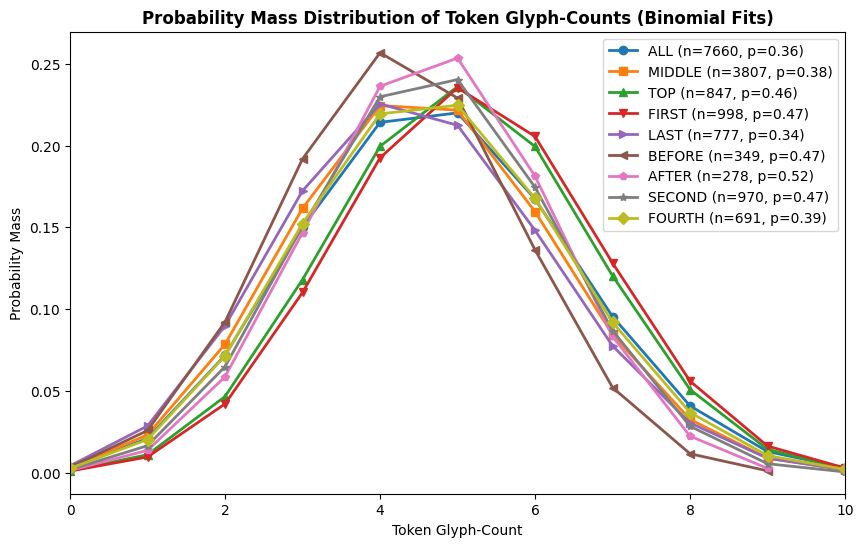

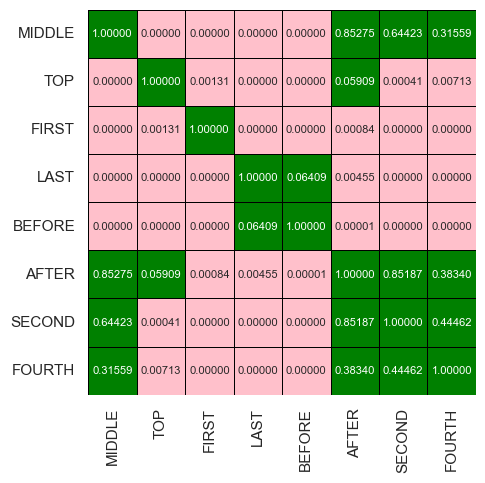

In [7]:
do_cohort_similarity_analysis('chi2', 'binomial', 
                              significance_threshold=.01,                               
                              cutoff=50,
                              smooth='minimal',
                              pmf_filename = 'voynich_data/outputs/F_PMFs_glyph_counts_ALL.png',
                             matrix_filename = 'voynich_data/outputs/F_Significance_Matrix.png')

## Plotting Distribution Pairs

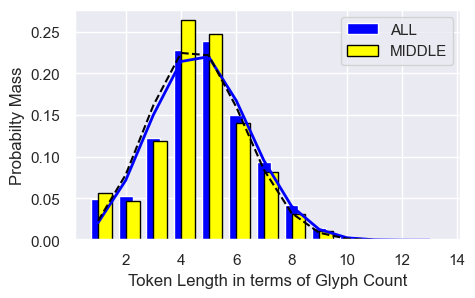

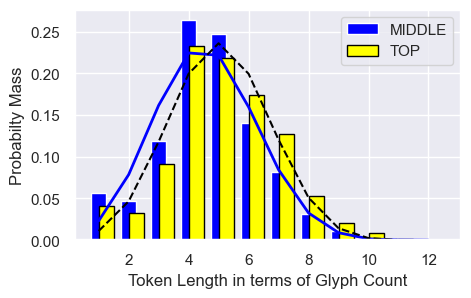

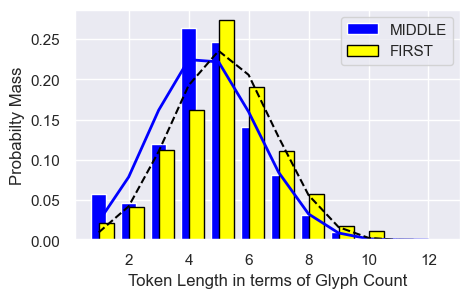

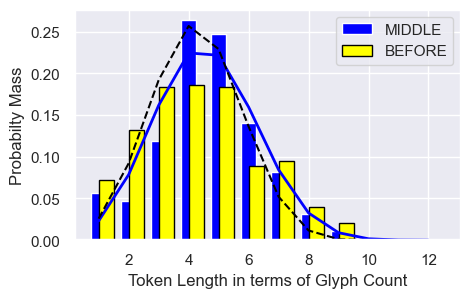

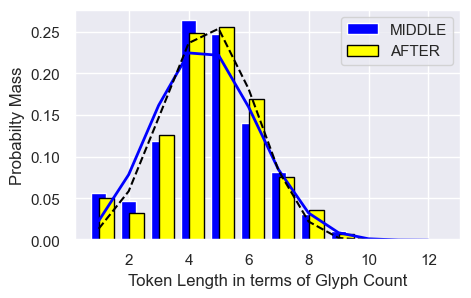

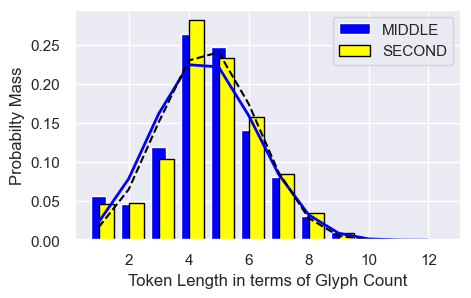

In [8]:
plots_to_do = [('ALL', 'MIDDLE'), ( 'MIDDLE', 'TOP'), ('MIDDLE', 'FIRST'), ('MIDDLE', 'BEFORE'),('MIDDLE', 'SECOND'), ('MIDDLE', 'AFTER')]
for i in range(len(all_cohorts)):
    x2 = all_cohorts[i]
    d2 = token_ws_by_c[x2]
    for j in range(i):
        x1 = all_cohorts[j]
        if not (x1,x2) in plots_to_do:
            continue
        d1 = token_ws_by_c[x1]
        plot_adjacent_histograms_with_binomial_curves(d1, d2, label1=x1, label2=x2, title='', #f"Comparison of {x1} and {x2}",
                                                     xlabel="Token Length in terms of Glyph Count",
                                                     ylabel="Probabilty Mass",
                                                     filename=f"voynich_data/outputs/F_PMF_Compare_{x1}_{x2}.png",
                                                      autoclose=False)
        